In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
# definerer parametre

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M
TNF = 0.5


In [6]:
t_samlet = (0, 30000)

N_n0, I_m0, I0, IKK_a0, IKK_i0 = 1, 0.01, 0.01, 0.01, 0.01

y0 = [N_n0, I_m0, I0, IKK_a0, IKK_i0]

In [7]:
#nu definerer vi ligninger til rungekutta

def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i):
    dN_ndt = k_Nin * (N_tot - N_n)*K_I/(K_I+I)-k_lin*I*N_n/(K_N + N_n)
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i):
    dI_mdt = k_t * N_n**2 - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i):
    dIdt = k_tl*I_m - alpha * IKK_a * (N_tot-N_n)*I/(K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt

def samlet_system_nfkb(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = N_n_change(t, *y)
    dydt[1] = I_m_change(t, *y)
    dydt[2] = I_change(t, *y)
    dydt[3] = IKK_a_change(t, *y)
    dydt[4] = IKK_i_change(t, *y)
    return dydt

In [8]:
samlethedNFKB = solve_ivp(samlet_system_nfkb, t_samlet, y0, method='RK45')

t, N_n, I_m, I, IKK_a, IKK_i = samlethedNFKB["t"], samlethedNFKB["y"][0], samlethedNFKB["y"][1], samlethedNFKB["y"][2], samlethedNFKB["y"][3], samlethedNFKB["y"][4]



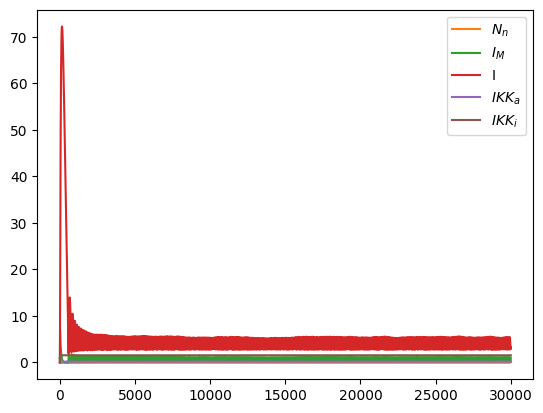

In [9]:
plt.plot(samlethedNFKB["t"], samlethedNFKB["y"][0])
plt.plot(t, N_n, label='$N_n$')
plt.plot(t, I_m, label='$I_M$')
plt.plot(t, I, label='I')
plt.plot(t, IKK_a, label='$IKK_a$')
plt.plot(t, IKK_i, label='$IKK_i$')
plt.legend()